# crns_calibration

- main editor: Haejo Kim, Syracuse University
- last edited: 2 Mar, 2024

---

This notebook shows our code of how our CRNS at the CARC was calibrated

In [1]:
# imports
import numpy as np
import pandas as pd
import numpy.ma as ma
import matplotlib.pyplot as plt
import seaborn as sns
import os
import glob
import seaborn as sns
import scipy
import matplotlib.ticker as mticker
import matplotlib.gridspec as gridspec
import matplotlib.colors as colors
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import pyproj

from lib.schron2017 import *

import warnings
warnings.filterwarnings('ignore')

# Processing CRNS
This notebook shows how CRNS data is processed for winter 2020-2021. First, read in the text file containing CRNS data.

In [2]:
# Data Processing ------------------------------------------------------------
# Read in CRNS data
crns_dat = pd.read_csv('./data/CRNS/CRNS_CARC_MT_20210601.txt',
       header=1,
       parse_dates=[0,14])

# Convert missing calues as NaNs
crns_dat[' N1 [cph]'] = crns_dat[' N1 [cph]'].where(crns_dat[' N1 [cph]']>2000, np.NaN)
crns_dat[' T7 [C]'] = crns_dat[' T7 [C]'].where(crns_dat[' T7 [C]']>-60, np.NaN)
crns_dat[' H7 [%]'] = crns_dat[' H7 [%]'].where(crns_dat[' H7 [%]']<=100, np.NaN)

## Calculating Correction Factors
The steps of converting CRNS to SWE measurements are outlined in a white paper document by Darin Desilets called "Calibrating a non-invasive cosmic ray soil moisture probe for snow water equivalent". CRNS data must be corrected for other environmental variables that can influence the baseline neutron flux and cause fluctuations in the raw counting rates.

We calculate a correction factor $F(t)$ which is applied to the raw counting rate, $N_{raw}$ as $$N = N_{raw}F(t)$$

We calculate 3 main corrections factors to normalize the counting rate to some reference point. The three main correction factors are for barometric pressure, solar activity, and atmospheric humidity where:
$$f_{bar} = \exp[\beta(p(t)-p_0]$$
$$f_{sol} = \frac{M_0}{M(t)}$$
$$f_{hum} = 1 + 0.0054 H(t)$$


The correction factor, $F(T)$ is calculated by multiplying the three corrections factors together
$$F(t) = f_{bar}f_{sol}f_{hum}$$

In [3]:
# Calculate Correction Factors
# counting rates (Raw, uncorrected)
N_raw = crns_dat[' N1 [cph]']

# choose calibration/reference period
cal_start = pd.Timestamp('2021-01-15T09', tz='MST').astimezone('UTC').to_datetime64()
cal_end = pd.Timestamp('2021-01-15T17', tz='MST').astimezone('UTC').to_datetime64()

### Barometric Pressure Correction
To correct for pressure, apply the formula:
$$f_{bar} = \exp[\beta(p(t) - p_0)]$$
for pressures, usually measured in hPa against a reference pressure, $p_0$

$\beta$ = 0.0077 hPa$^{-1}$

In [4]:
# F BAR
# constants
beta = 0.0077
# get pressures [p(t)]
p = crns_dat[' P4 [mb]']
# get calibration pressure, p0
p0 = crns_dat[(crns_dat['UTC']>cal_start) & (crns_dat['UTC']<cal_end)][' P4 [mb]'].mean()

f_bar = np.exp(beta*(p-p0))

### Solar activity Correction
Variations in solar energy will change the counting rate. The count rates are compated against a separate neutron monitoring station. The is correction factor is provided in the data. We did not calculate this separately.

In [5]:
# F SOL
f_sol = crns_dat[' fsol']

###  Humidity Correction Factor:
To calculate the humidity correction factor, the neutron rate is corrected using
$$f_{hum} = 1 + 0.0054H(t)$$
where $H(t)$ is the absolute humidity in $gm^{-3}$

To calculate absolute humidity, we calculate the saturation vapor pressure and then convert to absolute humidity using the following equations
$$e_w = 6.112\exp{\frac{17.62T}{243,12+T}}$$
$$H = \frac{U}{100}(\frac{e_wk}{T+273.16})$$
k is a constants and U is relative humidity. For more details, see Rosolem et al. (2013)

In [6]:
# F HUM
# get local temperature and humidity in CRNS data file
temp = crns_dat[' T7 [C]']
rh = crns_dat [' H7 [%]']

# constants
K = 216.68  # g k J^-1

# calculate sat_vap_pres
ew = 6.112 * np.exp((17.62*temp)/(243.12+temp))
# calculate abs humidity
H = (rh/100) * (ew*K)/(temp+273.16)
H0 = np.nanmean(H)
f_hum = 1 + (0.0054*(H0))

# # This is the "correct" method, but we run into weird issues...
# # Low humidity values which is mostly during the winter doesn't seem to affect our calculations
# # at the end
# # calculate abs. humidity of reference point
# rh_cal = crns_dat[(crns_dat['UTC']>cal_start) & (crns_dat['UTC']<cal_end)][' H7 [%]'].mean()
# T_cal = crns_dat[(crns_dat['UTC']>cal_start) & (crns_dat['UTC']<cal_end)][' T7 [C]'].mean()
# ew_cal = 6.112 * np.exp((17.62*T_cal)/(243.12+T_cal))
# h_cal = (rh_cal/100)*(ew_cal*K)/(T_cal+273.16)
# # f_hum = 1 + (0.0054*(H - h_cal))

From the three calculated correction factors, we can calculate the total correction factor and then correct the raw counting rate.

In [7]:
# total correction factor
F_t = f_bar*f_sol*f_hum

# calculate corrected counting rate, N
crns_dat['N'] = N_raw*F_t

### Soil Moisture Calibration
In addition, several soil moisture measurements were made as described in the manuscript. We used the Schron et al. (2017) method to calibrate our CRNS with respect to soil moisture surrounding the CRNS.

We took the supplemental material from Schron et al. (2017), HESS and imported them into python. The functions are located in `lib/schron2017.py` in our github repository. We then applied the calibration steps to obtain a calibrated volumetric soil moisture value that we used to calculate our SWE.

In [8]:
# Schron 2017 Calibration:

# process SM data
# read in SM data files. Repeats, one has lat/lon
sm1 = pd.read_csv('./data/SoilMoisture/CRNS_SoilMoisture.csv')
sm2 = pd.read_csv('./data/SoilMoisture/CRNS_SM_hkim.csv')
# drop unneeded columns and merge
sm2.drop(['GWC', 'Bulk_Density', 'Location', 'Depth_cm'], axis=1, inplace=True)
sm1 = sm1.join(sm2)
# get max depth of measurements
sm1['Depth'] = [float(sm1['Depth_cm'][i].split('-')[1]) for i in range(len(sm1))]
sm1.drop(['Depth_cm'], axis=1, inplace=True)

# convert lat/long to DTM
sm_x, sm_y = DTM(sm1['Longitude'], sm1['Latitude'])
sm1['UTMx'] = sm_x
sm1['UTMy'] = sm_y
# calculate distance from CRNS
sm1['r'] = np.sqrt((sm1['UTMx']-UTMx)**2 + (sm1['UTMy']-UTMy)**2)

sm1['Moisture_pct'] = sm1['Moisture_pct']/100

sm1['Moisture_pct'] = sm1['Moisture_pct'] + 0.067
sm1['Bulk_Density'] = sm1['Bulk_Density'] - 0.05

In [9]:
bd = np.round(sm1['Bulk_Density'].mean(),3)  # average bulk density  
x =  2.9 # Air Humidity  from 0.1  to 50    in g/m^3
y =  0.25 # Soil Moisture from 0.02 to  0.50 in m^3/m^3
p = 862.0125 # air pressure in mbar
Hveg = 0.0 # vegetation height in m

In [10]:
# Algorithm
m = 10  # num of iterations [-]
#1. initial value
tests = np.zeros([m,1]) # create zero vector
tests[0] = sm1['Moisture_pct'].mean() # fill first value with initial guess

# set initial values
i0 = sm1['Moisture_pct'].mean()

# loop and iterate
for j in range(m-1):
    print('initial guess: {}'.format(i0))
    #2. Calc penetration depth
    #3. vertically average the values for each profile
    #sm1['vws'] = Wd(sm1['Depth'], rscaled(sm1['r'], p, Hveg, i0), bd, sm1['Moisture_pct'])
    v_avgd_sm = []
    for pn in sm1['Location'].unique():
        sub = sm1[sm1['Location']==pn]
        vws = Wd(sub['Depth'], rscaled(sub['r'], p, Hveg, i0), sub['Bulk_Density'], sub['Moisture_pct'])
        v_avg = np.sum(vws*sub['Moisture_pct'])/np.sum(vws)
        v_avgd_sm.append(v_avg)
    # group by "profiles" for each location
    profiles = sm1.groupby(by='Location')[['Moisture_pct','r']].mean()

    # calculated vertically averaged SM
    profiles['Theta_p'] = v_avgd_sm

    #4. horizontally average the values
    # calculate the scaled r value
    # calculate all horizontal weights
    profiles['WrX'] = WrX(rscaled(profiles['r'], p, Hveg, i0), x, i0)
    profiles['WrA'] = WrA(rscaled(profiles['r'], p, Hveg, i0), x, i0)
    profiles['WrB'] = WrB(rscaled(profiles['r'], p, Hveg, i0), x, i0)
    
    profiles['r_scaled'] = rscaled(profiles['r'], p, Hveg, i0)
    # choose appropriate weights from r* vals
    profiles['hws'] = np.zeros([18,1])
    for i in range(len(profiles)):
        if profiles['r_scaled'][i] <= 1:
            profiles['hws'][i] = profiles['WrX'][i]
        elif (profiles['r_scaled'][i] > 1) & (profiles['r'][i] <= 50):
            profiles['hws'][i] = profiles['WrA'][i]
        else:
            profiles['hws'][i] = profiles['WrB'][i]

    # horizontally weigh average
    weighted_avg = np.sum(profiles['hws']*profiles['Theta_p'])/profiles['hws'].sum()
    #5. update initial value and run until convergence
    tests[j+1] = weighted_avg
    i0 = weighted_avg

initial guess: 0.20878070722681505
initial guess: 0.20469867417464782
initial guess: 0.20465564402159694
initial guess: 0.20465518887060208
initial guess: 0.20465518405608202
initial guess: 0.20465518400515473
initial guess: 0.20465518400461594
initial guess: 0.20465518400461033
initial guess: 0.20465518400461022


## Calculating SWE
Calculating SWE can be done using the formula:
$$SWE = -\Lambda \ln{\frac{N - N_{wat}}{N_\theta-N_{wat}}}$$

$\Lambda$ is an attenuation length and equal to 4.8 cm. $N_\theta$ is the zero-snow counting rate, or simply a reference neutron count that should be similarly set to the other reference points and preferably during a time when no snow is present. $N_{wat}$ is the theoretical counting rate over deep water. This value is experimentally derived to be
$$N_{wat} = 0.24N_0$$

$N_0$ is the theoretical counting rate over dry soils. This is found from the soil moisture calibration function from Desilets et al. (2010)
$$N_0 = \frac{F(t)N_\theta}{\frac{a_0}{\theta_g \rho_{bd}+a_2}+a_1}$$

Two pieces of information are needed which are the gravimetric water content ($\theta_g$) and soil bulk density ($\rho_{bd}$), which are collected during local sampling. $a_0$, $a_1$, and $a_2$ are constant values and their values are listed below.  

In [15]:
# N_theta: reference counting rate
N_cal = crns_dat[(crns_dat['UTC']>cal_start) & (crns_dat['UTC']<cal_end)].N.mean()

# constants for soil moisture calibration function
a0 = 0.0808
a1 = 0.3720
a2 = 0.1150

# Soil conditions for CARC. For our case, we used volumetric soil moisture instead of gravimetric.
theta = .204
rho = 1.136
bd = 1.086

# NOTE: Calibration was done using new research and a different scheme (see Schron et al. (2017)).
# Soil calibration was done after the winter season. So we set a new calibration start/end point to get
# the base counting rate to get N0
sm_cal_start = pd.Timestamp('2021-05-24T01', tz='MST').astimezone('UTC').to_datetime64()
sm_cal_end = pd.Timestamp('2021-05-24T23', tz='MST').astimezone('UTC').to_datetime64()

N_sm_cal = crns_dat[(crns_dat['UTC']>sm_cal_start) & (crns_dat['UTC']<sm_cal_end)]['N'].mean()

N0 = N_sm_cal /((a0/(theta/bd+a2))+a1)

# constants for SWE equation
N_wat = 0.24*N0
lamb = -4.8

# calculate swe
crns_dat['swe'] = lamb*np.log((crns_dat['N']-N_wat)/(N_cal-N_wat))
crns_dat['err'] = (4.8/(crns_dat['N'] - N_wat))*np.sqrt(crns_dat['N'])

In [29]:
# make the index to a datetime
crns_dat.index = crns_dat['UTC']
# resample crns to daily
crns_daily = crns_dat.resample('D').mean()
# get crns swe values and errors for lidar dates
crns_lidar_comp = crns_daily[['swe', 'err']].loc[['2021-01-21',
                                                  '2021-01-22',
                                                  '2021-01-29',
                                                  '2021-02-17',
                                                  '2021-02-18',
                                                  '2021-02-24',
                                                  '2021-03-04']]
# save to data
# crns_lidar_comp.to_csv('./data/CRNS/carc_crns_daily_swe_corrected_lidar_dates.csv')

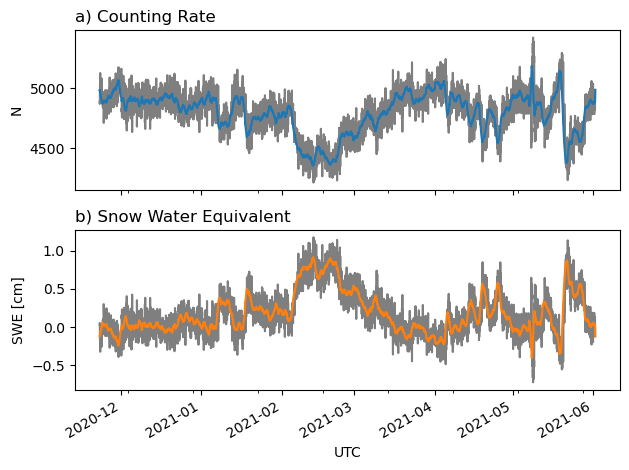

In [30]:
# VIZ data
fig, axs = plt.subplots(2, 1, sharex=True)

crns_dat.plot('UTC', 'N', ax=axs[0], legend=False, color='k', alpha=0.5)
crns_dat.plot('UTC', 'swe', ax=axs[1], legend=False, color='k', alpha=0.5)
crns_dat.set_index('UTC')['N'].rolling('D').mean().plot(ax=axs[0],
                                                        color='tab:blue')
crns_dat.set_index('UTC')['swe'].rolling('D').mean().plot(ax=axs[1],
                                                          color='tab:orange')
axs[0].set_ylabel('N')
axs[0].set_title('a) Counting Rate', loc='left')
axs[1].set_ylabel('SWE [cm]')
axs[1].set_title('b) Snow Water Equivalent', loc='left')
plt.tight_layout()
# plt.savefig('./figs/f5_python_ver.jpg',
#             bbox_inches='tight', facecolor='w', dpi=300)

References
- Desilets, D., Zreda, M., & Ferré, T. P. A. (2010). Nature’s neutron probe: Land surface hydrology at an elusive scale with cosmic rays: NATURE’S NEUTRON PROBE. Water Resources Research, 46(11). https://doi.org/10.1029/2009WR008726
- Desilets, D. (2017). Calibrating A Non-Invasive Cosmic Ray Soil Moisture For Snow Water Equivalent. https://doi.org/10.5281/ZENODO.439105
- Rosolem, R., Shuttleworth, W. J., Zreda, M., Franz, T. E., Zeng, X., & Kurc, S. A. (2013). The Effect of Atmospheric Water Vapor on Neutron Count in the Cosmic-Ray Soil Moisture Observing System. Journal of Hydrometeorology, 14(5), 1659–1671. https://doi.org/10.1175/JHM-D-12-0120.1
- Schrön, M., Köhli, M., Scheiffele, L., Iwema, J., Bogena, H. R., Lv, L., Martini, E., Baroni, G., Rosolem, R., Weimar, J., Mai, J., Cuntz, M., Rebmann, C., Oswald, S. E., Dietrich, P., Schmidt, U., & Zacharias, S. (2017). Improving calibration and validation of cosmic-ray neutron sensors in the light of spatial sensitivity. Hydrology and Earth System Sciences, 22. https://doi.org/10.5194/hess-21-5009-2017
